In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd

In [233]:
df = pd.read_csv('processed.csv')

In [234]:
df.head()

dist      addr hourse_type room_type  price  room_size  house_floor  \
0  文山區  政大二街131號        電梯大樓      整層住家  32000  116.03358          2.0   
1  大安區    羅斯福路三段        電梯大樓      獨立套房  21000   33.05800         12.0   
2  大安區     安和路二段        電梯大樓      整層住家  26030   85.95080          4.0   
3  大安區    復興南路一段        電梯大樓      獨立套房  26500   36.36380          3.0   
4  大安區    和平東路二段          公寓      整層住家  23009   76.03340          2.0   

   total_floor balcony      parking  
0         16.0     NaN  平面式停車位，已含租金  
1         12.0     NaN            無  
2          7.0     NaN            無  
3         10.0     樓中樓            無  
4          4.0     NaN            無

In [235]:
df['room_size'] = df.room_size.values*0.302500011
df['price_per_square'] = df.price.values/(df.room_size.values)

In [236]:
df.describe()

price     room_size  house_floor  total_floor  price_per_square
count  1.008300e+04  10083.000000  9666.000000  9666.000000      10083.000000
mean   4.142342e+04     30.761264     6.367887     9.333540       2530.086431
std    1.085894e+05    233.560892     5.888372     5.295164       4923.085311
min    2.500000e+02      1.000005    -2.000000     1.000000          1.045450
25%    1.200000e+04      8.000036     3.000000     5.000000        851.255064
50%    2.900000e+04     18.000082     5.000000     8.000000       1476.008064
75%    5.199900e+04     40.000181     8.000000    13.000000       2522.728570
max    9.999999e+06  22000.099800    30.000000    33.000000     232557.061316

In [237]:
df_new = df[df.room_type!='其他']
df_new = df_new[df_new.room_type!='車位']
df_new = df_new[df_new.hourse_type!='辦公商業大樓']

In [238]:
df_new.hourse_type.value_counts()

電梯大樓    6106
公寓      2863
透天厝      336
別墅        93
住宅大樓      23
華廈        13
Name: hourse_type, dtype: int64

In [240]:
# 捨棄門牌
for index,i in enumerate(df_new.addr):
    if len(i.split('段'))>1:
        df_new.loc[index, 'road'] = (i.split('段')[0]+'段')
    elif len(i.split('街'))>1:
        if i.split('街')[-1] == '':
            df_new.loc[index, 'road'] = (i.split('街')[0]+'街')
        elif len(i.split('巷'))>1:
            if i.split('巷')[-1] == '':
                df_new.loc[index, 'road'] = (i.split('巷')[0]+'巷')
        else:
            df_new.loc[index, 'road'] = (i.split('街')[0]+'街')
    elif len(i.split('路'))>1:
        df_new.loc[index, 'road'] = (i.split('路')[0]+'路')
    else:
        df_new.loc[index, 'road'] = (i.split('路'))

In [202]:
# dftemp = df_new.groupby(['dist', 'road']).mean()[df_new.groupby(['dist', 'road']).mean().index.get_level_values('dist')=='中山區']
# dftemp.sort_values('price_per_square')

# groupby method

In [204]:
def groupby_price_dataframe(group):
    # mean
    df_price = group.mean()
    df_price.rename(columns={"price":"price_mean", "price_per_square":"price_per_square_mean",
                            "room_size":"room_size_mean", "house_floor":"house_floor_mean",
                            'total_floor':'total_floor_mean'}, inplace=True)
    # median
    df_price['price_median'] = group.median()['price']
    df_price['price_per_square_median'] = group.median()['price_per_square']
    df_price['room_size_median'] = group.median()['room_size']
    df_price['house_floor_median'] = group.median()['house_floor']
    df_price['total_floor_median'] = group.median()['total_floor']

    # mode
    group.agg(lambda x: np.mean(pd.Series.mode(x)))#.reset_index()
    df_price['price_mode'] = group.agg(lambda x: np.mean(pd.Series.mode(x)))['price']
    df_price['price_per_square_mode'] = group.agg(lambda x: np.mean(pd.Series.mode(x)))['price_per_square']
    df_price['room_size_mode'] = group.agg(lambda x: np.mean(pd.Series.mode(x)))['room_size']
    df_price['house_floor_mode'] = group.agg(lambda x: np.mean(pd.Series.mode(x)))['house_floor']
    df_price['total_floor_mode'] = group.agg(lambda x: np.mean(pd.Series.mode(x)))['total_floor']
    
    return df_price

In [205]:
def dist_trans(df):
    for i in df.index:
        d = df.loc[i, 'dist']
        if d == "松山區":
            df.loc[i, 'dist'] = 'Songshan'
        elif d == "南港區":
            df.loc[i, 'dist'] = 'Nangang'
        elif d == "大同區":
            df.loc[i, 'dist'] = 'Datong'
        elif d == "信義區":
            df.loc[i, 'dist'] = 'Xinyi'
        elif d == "大安區":
            df.loc[i, 'dist']= 'Daan'
        elif d == "士林區":
            df.loc[i, 'dist']= 'Shilin'
        elif d == "萬華區":
            df.loc[i, 'dist']= 'Wanhua'
        elif d == "中正區":
            df.loc[i, 'dist'] = 'Zhongzheng'
        elif d == "文山區":
            df.loc[i, 'dist'] = 'Wenshan'
        elif d == "中山區":
            df.loc[i, 'dist'] = 'Zhongshan'
        elif d == "內湖區":
            df.loc[i, 'dist'] = 'Neihu'
        elif d == "北投區":
            df.loc[i, 'dist'] = 'Beitou'
    return df

In [241]:
df_new=dist_trans(df_new)
df_new

dist           addr hourse_type room_type    price  room_size  \
0        Wenshan       政大二街131號        電梯大樓      整層住家  32000.0  35.100159   
1           Daan         羅斯福路三段        電梯大樓      獨立套房  21000.0  10.000045   
2           Daan          安和路二段        電梯大樓      整層住家  26030.0  26.000118   
3           Daan         復興南路一段        電梯大樓      獨立套房  26500.0  11.000050   
4           Daan         和平東路二段          公寓      整層住家  23009.0  23.000104   
5         Shilin      忠誠路二段118巷         透天厝        雅房   9000.0   8.000036   
6      Zhongshan     中山北路二段168號        電梯大樓      整層住家  46800.0  44.000200   
7     Zhongzheng      南昌路二段164號          公寓      獨立套房  10000.0   5.000023   
8         Wanhua         雅江街50號          公寓      分租套房  14500.0   8.000036   
9           Daan  忠孝東路四段216巷16號        電梯大樓      獨立套房  26800.0  10.000045   
10      Songshan      南京東路四段53巷          公寓      整層住家  26000.0  25.000113   
11    Zhongzheng        廈門街123巷          公寓      獨立套房  10000.0  10.000045   
12        Datong       長安西路145巷          公寓      獨立套房  19000.0  10.000045   
13        Datong            寧夏路        電梯大樓      整層住家  33000.0  19.000086   
14        Shilin      忠誠路二段118巷         透天厝      分租套房  10000.0   8.000036   
15          Daan         敦化南路一段        電梯大樓      獨立套房  26000.0  13.000059   
16          Daan   通化街171巷30弄1號          公寓      整層住家  29000.0  20.000091   
17    Zhongzheng         市民大道一段        電梯大樓      整層住家  55000.0  30.500138   
19        Shilin        中正路450號        電梯大樓      整層住家  78000.0  50.000227   
20          Daan           光復南路        電梯大樓        雅房   8925.0   9.000041   
21         Xinyi        吳興街284巷          公寓      獨立套房   8900.0   8.000036   
22         Xinyi     吳興街284巷26號          公寓      整層住家  36000.0  30.000136   
23         Xinyi           光復南路        電梯大樓      獨立套房  30000.0  14.650066   
24     Zhongshan            農安街        電梯大樓      獨立套房  14500.0   7.500034   
25     Zhongshan   中山北路二段183巷4號          公寓        雅房   5500.0   3.500016   
26         Xinyi        嘉興街216巷        電梯大樓      分租套房  12500.0   6.500029   
27          Daan       大安路一段52巷          公寓      獨立套房  19800.0  10.000045   
28          Daan         和平東路一段        電梯大樓      整層住家  36000.0  20.000091   
29        Shilin         重慶北路四段          公寓      獨立套房   8800.0   8.000036   
30         Xinyi            福德街          公寓        雅房   8000.0   6.000027   
...          ...            ...         ...       ...      ...        ...   
9125         NaN            NaN         NaN       NaN      NaN        NaN   
9129         NaN            NaN         NaN       NaN      NaN        NaN   
9136         NaN            NaN         NaN       NaN      NaN        NaN   
9142         NaN            NaN         NaN       NaN      NaN        NaN   
9174         NaN            NaN         NaN       NaN      NaN        NaN   
9192         NaN            NaN         NaN       NaN      NaN        NaN   
9196         NaN            NaN         NaN       NaN      NaN        NaN   
9205         NaN            NaN         NaN       NaN      NaN        NaN   
9213         NaN            NaN         NaN       NaN      NaN        NaN   
9220         NaN            NaN         NaN       NaN      NaN        NaN   
9222         NaN            NaN         NaN       NaN      NaN        NaN   
9224         NaN            NaN         NaN       NaN      NaN        NaN   
9237         NaN            NaN         NaN       NaN      NaN        NaN   
9245         NaN            NaN         NaN       NaN      NaN        NaN   
9250         NaN            NaN         NaN       NaN      NaN        NaN   
9256         NaN            NaN         NaN       NaN      NaN        NaN   
9259         NaN            NaN         NaN       NaN      NaN        NaN   
9297         NaN            NaN         NaN       NaN      NaN        NaN   
9324         NaN            NaN         NaN       NaN      NaN        NaN   
9334         NaN            NaN         NaN       NaN      NaN        NaN   
9349    

In [207]:
def roomtype_trans(df):
    for i in df.index:
        d = df.loc[i, 'room_type']
        if d == "整層住家":
            df.loc[i, 'room_type'] = 'A'
        elif d == "獨立套房":
            df.loc[i, 'room_type'] = 'B'
        elif d == "分租套房":
            df.loc[i, 'room_type'] = 'C'
        elif d == "雅房":
            df.loc[i, 'room_type'] = 'D'
    return df

In [242]:
df_new=roomtype_trans(df_new)
df_new

dist           addr hourse_type room_type    price  room_size  \
0        Wenshan       政大二街131號        電梯大樓         A  32000.0  35.100159   
1           Daan         羅斯福路三段        電梯大樓         B  21000.0  10.000045   
2           Daan          安和路二段        電梯大樓         A  26030.0  26.000118   
3           Daan         復興南路一段        電梯大樓         B  26500.0  11.000050   
4           Daan         和平東路二段          公寓         A  23009.0  23.000104   
5         Shilin      忠誠路二段118巷         透天厝         D   9000.0   8.000036   
6      Zhongshan     中山北路二段168號        電梯大樓         A  46800.0  44.000200   
7     Zhongzheng      南昌路二段164號          公寓         B  10000.0   5.000023   
8         Wanhua         雅江街50號          公寓         C  14500.0   8.000036   
9           Daan  忠孝東路四段216巷16號        電梯大樓         B  26800.0  10.000045   
10      Songshan      南京東路四段53巷          公寓         A  26000.0  25.000113   
11    Zhongzheng        廈門街123巷          公寓         B  10000.0  10.000045   
12        Datong       長安西路145巷          公寓         B  19000.0  10.000045   
13        Datong            寧夏路        電梯大樓         A  33000.0  19.000086   
14        Shilin      忠誠路二段118巷         透天厝         C  10000.0   8.000036   
15          Daan         敦化南路一段        電梯大樓         B  26000.0  13.000059   
16          Daan   通化街171巷30弄1號          公寓         A  29000.0  20.000091   
17    Zhongzheng         市民大道一段        電梯大樓         A  55000.0  30.500138   
19        Shilin        中正路450號        電梯大樓         A  78000.0  50.000227   
20          Daan           光復南路        電梯大樓         D   8925.0   9.000041   
21         Xinyi        吳興街284巷          公寓         B   8900.0   8.000036   
22         Xinyi     吳興街284巷26號          公寓         A  36000.0  30.000136   
23         Xinyi           光復南路        電梯大樓         B  30000.0  14.650066   
24     Zhongshan            農安街        電梯大樓         B  14500.0   7.500034   
25     Zhongshan   中山北路二段183巷4號          公寓         D   5500.0   3.500016   
26         Xinyi        嘉興街216巷        電梯大樓         C  12500.0   6.500029   
27          Daan       大安路一段52巷          公寓         B  19800.0  10.000045   
28          Daan         和平東路一段        電梯大樓         A  36000.0  20.000091   
29        Shilin         重慶北路四段          公寓         B   8800.0   8.000036   
30         Xinyi            福德街          公寓         D   8000.0   6.000027   
...          ...            ...         ...       ...      ...        ...   
9125         NaN            NaN         NaN       NaN      NaN        NaN   
9129         NaN            NaN         NaN       NaN      NaN        NaN   
9136         NaN            NaN         NaN       NaN      NaN        NaN   
9142         NaN            NaN         NaN       NaN      NaN        NaN   
9174         NaN            NaN         NaN       NaN      NaN        NaN   
9192         NaN            NaN         NaN       NaN      NaN        NaN   
9196         NaN            NaN         NaN       NaN      NaN        NaN   
9205         NaN            NaN         NaN       NaN      NaN        NaN   
9213         NaN            NaN         NaN       NaN      NaN        NaN   
9220         NaN            NaN         NaN       NaN      NaN        NaN   
9222         NaN            NaN         NaN       NaN      NaN        NaN   
9224         NaN            NaN         NaN       NaN      NaN        NaN   
9237         NaN            NaN         NaN       NaN      NaN        NaN   
9245         NaN            NaN         NaN       NaN      NaN        NaN   
9250         NaN            NaN         NaN       NaN      NaN        NaN   
9256         NaN            NaN         NaN       NaN      NaN        NaN   
9259         NaN            NaN         NaN       NaN      NaN        NaN   
9297         NaN            NaN         NaN       NaN      NaN        NaN   
9324         NaN            NaN         NaN       NaN      NaN        NaN   
9334         NaN            NaN         NaN       NaN      NaN        NaN   
9349    

In [243]:
df_new=df_new[df_new.price_per_square>100] # 坪數有誤

In [244]:
df_new.price_per_square.mean()

2603.5578072933667

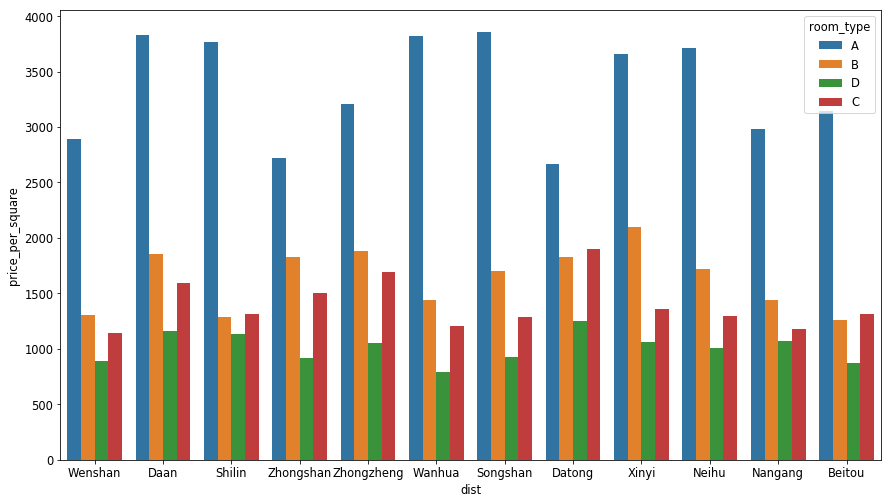

In [245]:
fig = plt.figure(figsize=(14.7, 8.27))
sns.barplot(x=df_new.dist, y=df_new.price_per_square, hue=df_new.room_type, data=df_new, ci=None)

A 房型平均租金:  3404.835686319477


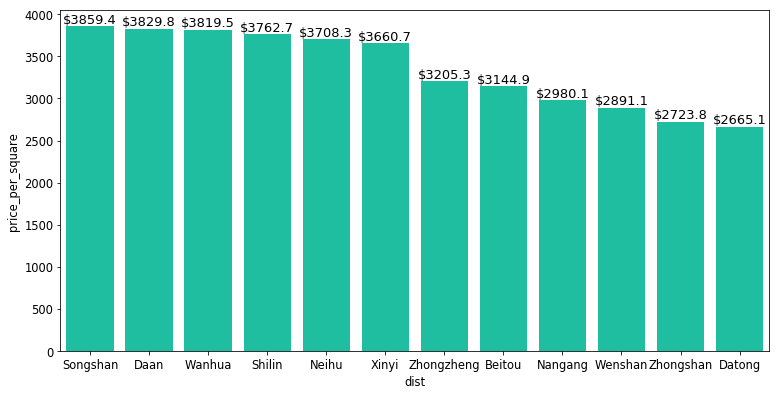

B 房型平均租金:  1716.8098200514044


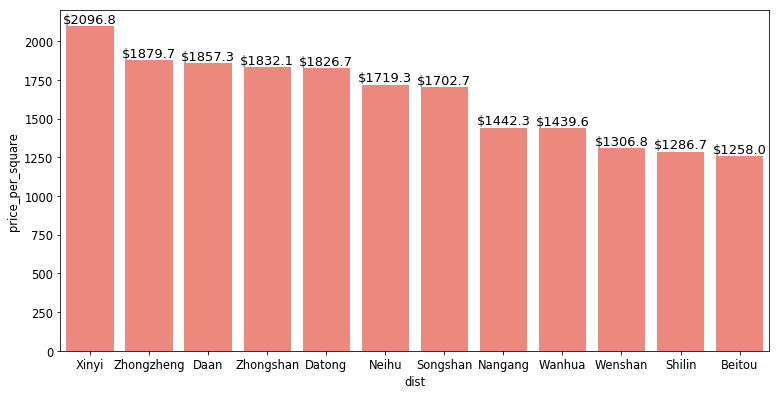

C 房型平均租金:  1390.0343502740384


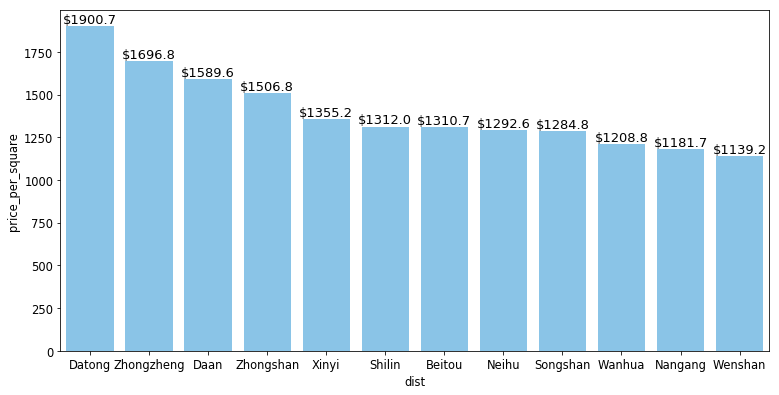

D 房型平均租金:  1025.7675567490737


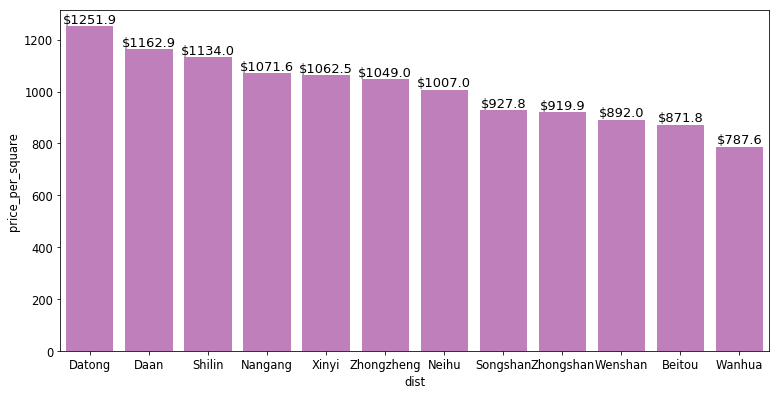

In [246]:
color = ['xkcd:aquamarine', 'xkcd:salmon', 'xkcd:lightblue', 'xkcd:orchid']
for index,i in enumerate(['A', 'B', 'C', 'D']): # 整層住家/獨立套房/分租套房/雅房
    colors = color[index]
    
    fig = plt.figure(figsize=(12.7, 6.27))
    df_plot=df_new[df_new.room_type==i]
    print(i, '房型平均租金: ', df_plot.price_per_square.mean())
    df_plot = df_plot.groupby('dist').mean().sort_values('price_per_square', ascending=False)
    ax = sns.barplot(x=df_plot.index, y=df_plot.price_per_square, data=df_plot, ci=None, color=colors)
    # text
    for i,p in enumerate(ax.patches):
        x=p.get_bbox().get_points()[:,0] # x 寬度
        price=p.get_bbox().get_points()[1,1] # y 高度
    #     print(x,price)

        ax.annotate('${0:.1f}'.format(price), (x.mean(), price), 
                    ha='center', va='bottom', size='13') # set the alignment of the text
    plt.show()

([<matplotlib.patches.Wedge at 0x7fe71a01ddd8>,
 [Text(0.92590358040924, 0.5938876659649955, 'Zhongshan'),
  Text(0.014918849296514162, 1.0998988262270617, 'Daan'),
  Text(-0.7729180895544484, 0.782686161139637, 'Xinyi'),
  Text(-1.0981330176916966, 0.06406149744837618, 'Shilin'),
  Text(-0.8947009751274929, -0.6399298126403501, 'Neihu'),
  Text(-0.4513442936280634, -1.0031392369005334, 'Beitou'),
  Text(-0.026704788921312127, -1.0996757950635578, 'Zhongzheng'),
  Text(0.3564816562489325, -1.040634820077638, 'Songshan'),
  Text(0.65556045276071, -0.8833122283633196, 'Datong'),
  Text(0.878569259113597, -0.6619033592153659, 'Wanhua'),
  Text(1.0237976181288921, -0.4022914827753718, 'Wenshan'),
  Text(1.0919267327917814, -0.1330263515799244, 'Nangang')],
 [Text(0.5050383165868582, 0.32393872688999753, '18.15%  (1703)'),
  Text(0.008137554161734997, 0.5999448143056699, '13.26%  (1244)'),
  Text(-0.42159168521151724, 0.4269197242579838, '11.97%  (1123)'),
  Text(-0.5989816460136526, 0.0349

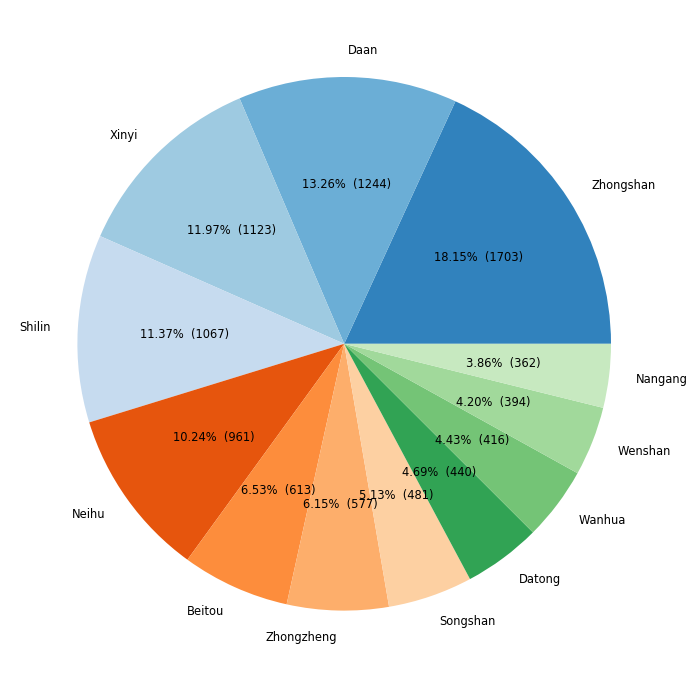

In [80]:
# 租屋物件數量
df_plot = df_new.dist.value_counts()

fig = plt.figure(figsize=(12.7, 12.27))
# ax = fig.add_subplot(111)

# 顯示 %數 個數
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


# 設置 pie chart color
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(df_plot)))

import matplotlib as mpl
mpl.rcParams['font.size'] = 11.5 # 設置 fontsize

plt.pie( df_plot.values,
    labels = df_plot.index,
    colors = outer_colors,
#     autopct='%1.1f%%', # 顯示 %
    autopct=make_autopct(df_plot.values) # 顯示 % +個數
    ) 

# map

In [17]:
# -------------- setting --------------- #
groupby_method = '一層'
# -------------------------------------- #

In [18]:
if groupby_method == '兩層':
    # 兩層 index
    group = df_new.groupby(['dist', 'room_type'])
    df_price = groupby_price_dataframe(group)
    # df_price.to_csv('multiindex_price.csv')
elif groupby_method == '一層':
    # 一層 index
    d_group = df_new.groupby('dist')
    df_price = groupby_price_dataframe(d_group)
    # df_price.to_csv('dict_index_price.csv')
df_price

price_mean  room_size_mean  house_floor_mean  total_floor_mean  \
dist                                                                           
Beitou      34980.681892       85.354618          6.570962          8.817292   
Daan        47446.876206       95.828599          6.340032          9.536174   
Datong      34245.895455       83.211945          6.320455          9.838636   
Nangang     38978.309392       90.213949          6.892265          9.718232   
Neihu       45064.534860       95.742638          6.678460          9.206035   
Shilin      49367.522024      101.844733          5.959700          7.205248   
Songshan    41617.783784       82.699377          6.237006          9.212058   
Wanhua      49806.776442       73.107341          6.956731         12.192308   
Wenshan     18264.172589       66.448971          6.058376          6.779188   
Xinyi       50656.772039       92.783659          7.116652         10.807658   
Zhongshan   40326.001174       91.916637          6.016442          9.920141   
Zhongzheng  36609.828423       77.120435          5.682842          8.369151   

            price_per_square_mean  price_median  price_per_square_median  \
dist                                                                       
Beitou                 695.657571       25000.0               410.729452   
Daan                   895.867617       38000.0               523.212094   
Datong                 704.158952       32000.0               484.488452   
Nangang                685.506225       27750.0               434.504452   
Neihu                  874.724673       36000.0               453.747958   
Shilin                 861.819699       38000.0               428.539738   
Songshan               833.248338       27999.0               458.069367   
Wanhua                 777.233883       23999.5               426.018916   
Wenshan                517.671889       11000.0               358.357762   
Xinyi                  877.091695       34999.0               519.704584   
Zhongshan              698.504558       29999.0               478.956178   
Zhongzheng             734.070791       25500.0               489.759701   

            room_size_median  house_floor_median  total_floor_median  \
dist                                                                   
Beitou             56.198600                 4.0                 7.0   
Daan               67.537494                 5.0                 7.0   
Datong             49.884522                 5.0                12.0   
Nangang            66.116000                 5.0                 7.0   
Neihu              64.562274                 5.0                 8.0   
Shilin             78.810272                 4.0                 6.0   
Songshan           52.892800                 5.0                 7.0   
Wanhua             49.587000                 6.0                12.0   
Wenshan            33.058000                 4.0                 5.0   
Xinyi              65.917652                 5.0                11.0   
Zhongshan          59.107704                 5.0                11.0   
Zhongzheng         47.934100                 4.0                 7.0   

            price_mode  price_per_square_mode  room_size_mode  \
dist                                                            
Beitou           10000             604.997278         16.5290   
Daan             60000             604.997278         16.5290   
Datong           55000            1096.557565         26.4464   
Nangang           8000             302.498639         19.8348   
Neihu            45000             604.997278         16.5290   
Shilin            9000             604.997278         16.5290   
Songshan         55000             561.783186         16.5290   
Wanhua           26000             604.997278         19.8348   
Wenshan           8000             453.747958         19.8348   
Xinyi            55000             544.497550         21.4877   
Zhongshan        25000             604.

In [19]:
# 樓層資料
df_floor = df_price[['room_size_mean', 'house_floor_mean', 'total_floor_mean',
         'room_size_median', 'house_floor_median', 'total_floor_median',
         'room_size_mode','house_floor_mode', 'total_floor_mode']]
# 價格資料
df_price = df_price[['price_mean', 'price_median', 'price_mode',
                     'price_per_square_mean','price_per_square_median', 'price_per_square_mode']]

# 台北市各區中心經緯度

In [20]:
# df_d = pd.read_csv("dict_data.csv")
# df_d = df_d[:12] # 取台北市
# df_d.drop(columns=['_x0033_碼郵遞區號', 'TGOS_URL'], inplace=True)
# df_d.head()

In [21]:
# from shapely.geometry import Point
# geom = [Point(xy) for xy in zip(df_d['中心點經度'], df_d['中心點緯度'])]
# dfd_shp = gpd.GeoDataFrame(df_d, geometry=geom) # 轉經緯度格式
# dfd_shp.plot()

# 行政區域

In [22]:
villages_shp = gpd.read_file("mapdata/TOWN_MOI_1080509.shp",encoding='utf-8') #全台灣村里界圖
tpe_shp = villages_shp.query('COUNTYNAME=="臺北市"') # 取出台北市
tpe_shp=tpe_shp.sort_values('TOWNENG')

In [23]:
tpe_shp.head()

TOWNID  TOWNCODE COUNTYNAME TOWNNAME           TOWNENG COUNTYID  \
351    A16  63000120        臺北市      北投區   Beitou District        A   
151    A02  63000030        臺北市      大安區     Daan District        A   
347    A09  63000060        臺北市      大同區   Datong District        A   
345    A13  63000090        臺北市      南港區  Nangang District        A   
349    A14  63000100        臺北市      內湖區    Neihu District        A   

    COUNTYCODE                                           geometry  
351      63000  POLYGON ((121.559902986 25.21014324000004, 121...  
151      63000  POLYGON ((121.543841724 25.04490669700004, 121...  
347      63000  POLYGON ((121.5141047090001 25.07941577800005,...  
345      63000  POLYGON ((121.614250201 25.06451252200009, 121...  
349      63000  POLYGON ((121.5935900530001 25.11514551600004,...

# 合併 房屋價格資料與地圖邊界資料

In [24]:
price_shp = gpd.GeoDataFrame(df_price)
price_shp=price_shp.sort_index()
price_shp['geometry'] = tpe_shp['geometry'].values
price_shp

price_mean  price_median  price_mode  price_per_square_mean  \
dist                                                                        
Beitou      34980.681892       25000.0       10000             695.657571   
Daan        47446.876206       38000.0       60000             895.867617   
Datong      34245.895455       32000.0       55000             704.158952   
Nangang     38978.309392       27750.0        8000             685.506225   
Neihu       45064.534860       36000.0       45000             874.724673   
Shilin      49367.522024       38000.0        9000             861.819699   
Songshan    41617.783784       27999.0       55000             833.248338   
Wanhua      49806.776442       23999.5       26000             777.233883   
Wenshan     18264.172589       11000.0        8000             517.671889   
Xinyi       50656.772039       34999.0       55000             877.091695   
Zhongshan   40326.001174       29999.0       25000             698.504558   
Zhongzheng  36609.828423       25500.0       10000             734.070791   

            price_per_square_median  price_per_square_mode  \
dist                                                         
Beitou                   410.729452             604.997278   
Daan                     523.212094             604.997278   
Datong                   484.488452            1096.557565   
Nangang                  434.504452             302.498639   
Neihu                    453.747958             604.997278   
Shilin                   428.539738             604.997278   
Songshan                 458.069367             561.783186   
Wanhua                   426.018916             604.997278   
Wenshan                  358.357762             453.747958   
Xinyi                    519.704584             544.497550   
Zhongshan                478.956178             604.997278   
Zhongzheng               489.759701             604.997278   

                                                     geometry  
dist                                                           
Beitou      POLYGON ((121.559902986 25.21014324000004, 121...  
Daan        POLYGON ((121.543841724 25.04490669700004, 121...  
Datong      POLYGON ((121.5141047090001 25.07941577800005,...  
Nangang     POLYGON ((121.614250201 25.06451252200009, 121...  
Neihu       POLYGON ((121.5935900530001 25.11514551600004,...  
Shilin      POLYGON ((121.580883371 25.19535329300004, 121...  
Songshan    POLYGON ((121.5697062800001 25.07629222800006,...  
Wanhua      POLYGON ((121.5052060700001 25.04949036400006,...  
Wenshan     POLYGON ((121.5972524900001 25.01438526800007,...  
Xinyi       POLYGON ((121.579950627 25.04950413500006, 121...  
Zhongshan   POLYGON ((121.5414663030001 25.09287088400004,...  
Zhongzheng  POLYGON ((121.5134137450001 25.04939843500006,...

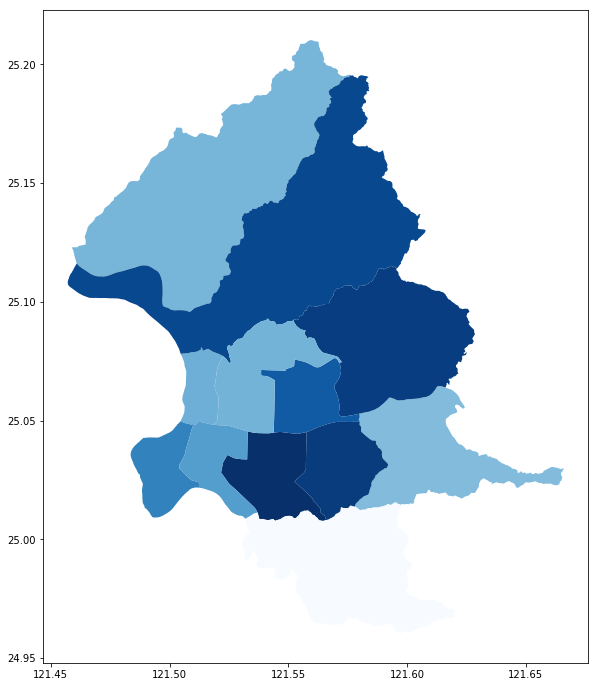

In [26]:
price_shp.plot(
    cmap=plt.cm.Blues, #指定顏色
    column='price_per_square_mean', #指定從自身的這個 column 讀取顏色深度
    figsize=(12,12)
)
plt.show()

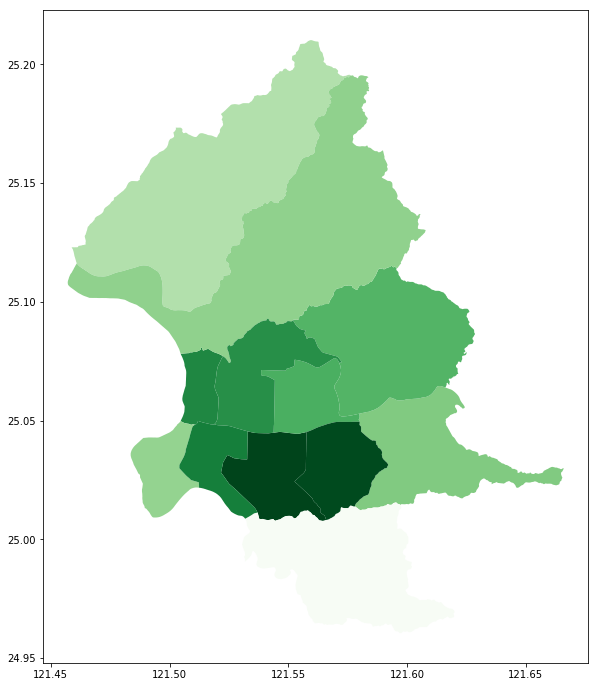

In [27]:
price_shp.plot(
    cmap=plt.cm.Greens, #指定顏色
    column='price_per_square_median', #指定從自身的這個 column 讀取顏色深度
    figsize=(12,12)
)
plt.show()

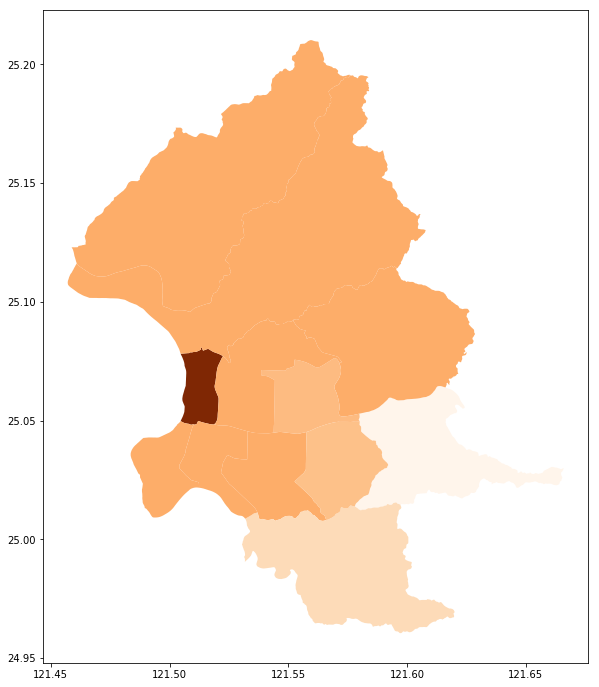

In [28]:
ax=price_shp.plot(
    cmap=plt.cm.Oranges, #指定顏色
    column='price_per_square_mode', #指定從自身的這個 column 讀取顏色深度
    figsize=(12,12)
)
# dfd_shp.plot(ax=ax) # 疊圖
plt.show()

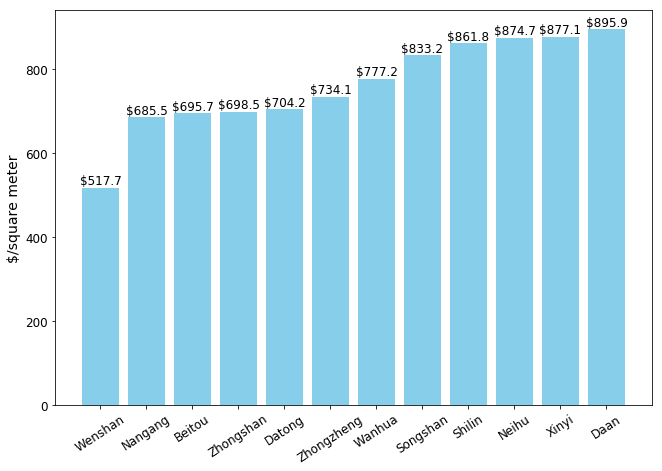

In [29]:
# 平均數
df_plot = df_price.sort_values('price_per_square_mean')

fig = plt.figure(figsize=(10.7, 7.27))
ax = fig.add_subplot(111)

ax.set_ylabel("$/square meter", fontsize=14) #設定y軸名稱
# ax.set_xlabel("Distinct", fontsize=14) #設定x軸名稱
ax.tick_params(axis='x', rotation=33, labelsize=12) #設定tick
ax.tick_params(axis='y', rotation=0, labelsize=12) #設定tick

ax.bar(df_plot.index, df_plot.price_per_square_mean, color='skyblue')

# text
for i,p in enumerate(ax.patches):
    x=p.get_bbox().get_points()[:,0] # x 寬度
    price=p.get_bbox().get_points()[1,1] # y 高度
#     print(x,price)
    
    ax.annotate('${0:.1f}'.format(price), (x.mean(), price), 
                ha='center', va='bottom', size='12') # set the alignment of the text

plt.show()

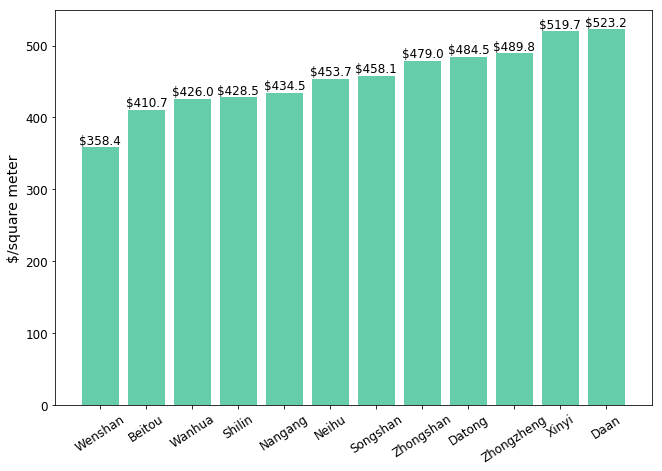

In [30]:
# 中位數
df_plot = df_price.sort_values('price_per_square_median')

fig = plt.figure(figsize=(10.7, 7.27))
ax = fig.add_subplot(111)

ax.set_ylabel("$/square meter", fontsize=14) #設定y軸名稱
# ax.set_xlabel("Distinct", fontsize=14) #設定x軸名稱
ax.tick_params(axis='x', rotation=33, labelsize=12) #設定tick
ax.tick_params(axis='y', rotation=0, labelsize=12) #設定tick

ax.bar(df_plot.index, df_plot.price_per_square_median, color='mediumaquamarine')

# text
for i,p in enumerate(ax.patches):
    x=p.get_bbox().get_points()[:,0] # x 寬度
    price=p.get_bbox().get_points()[1,1] # y 高度
#     print(x,price)
    
    ax.annotate('${0:.1f}'.format(price), (x.mean(), price), 
                ha='center', va='bottom', size='12') # set the alignment of the text

plt.show()

# 分布圖

In [31]:
import seaborn as sns

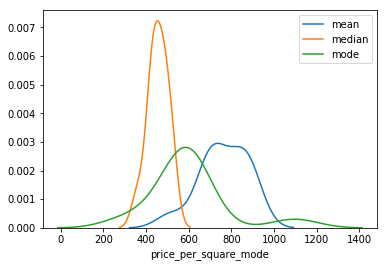

In [32]:
sns.distplot(df_price.price_per_square_mean, hist=False, label='mean')
sns.distplot(df_price.price_per_square_median,hist=False, label='median')
sns.distplot(df_price.price_per_square_mode,hist=False, label='mode')
plt.legend()

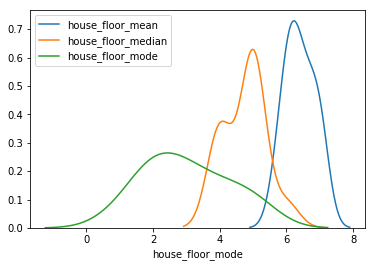

In [33]:
sns.distplot(df_floor.house_floor_mean, hist=False, label='house_floor_mean')
sns.distplot(df_floor.house_floor_median, hist=False, label='house_floor_median')
sns.distplot(df_floor.house_floor_mode, hist=False, label='house_floor_mode')
plt.legend()

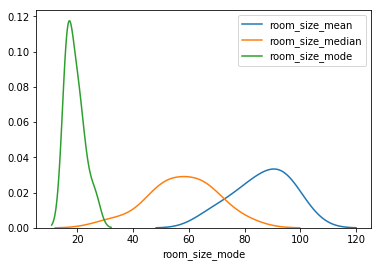

In [34]:
sns.distplot(df_floor.room_size_mean, hist=False, label='room_size_mean')
sns.distplot(df_floor.room_size_median, hist=False, label='room_size_median')
sns.distplot(df_floor.room_size_mode, hist=False, label='room_size_mode')
plt.legend()